In [ ]:
#Testing for google collab

In [1]:
#TODO Make the augmentation function for the dataset

In [ ]:
#Importing necessary libraries and modules
import tensorflow as tf
import cv2 as cv
import numpy as np
import h5py
import scipy.io
import matplotlib.pyplot as plt
from PIL import Image
import os
import sklearn
import csv

2024-07-17 02:39:05.139512: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-17 02:39:08.041658: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
#Setting gpu growth rate to prevent OOM error
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

2024-07-01 21:35:57.070187: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 21:35:57.393175: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 21:35:57.393812: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
#Data Extraction
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 8
seed = 15
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/home/darklord/Downloads/hand_dataset/training_dataset/training_data/images/',
    labels = None,
    label_mode= None,
    batch_size= batch_size,
    seed=seed
)
raw_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/home/darklord/Downloads/hand_dataset/validation_dataset/validation_data/images/',
    labels = None,
    label_mode= None,
    batch_size= batch_size,
    seed=seed
)
raw_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/home/darklord/Downloads/hand_dataset/test_dataset/test_data/images/',
    labels = None,
    label_mode= None,
    batch_size= batch_size,
    seed=seed
)

Found 4069 files belonging to 1 classes.


2024-07-01 21:37:05.471261: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 21:37:05.471845: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 21:37:05.472006: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 738 files belonging to 1 classes.
Found 821 files belonging to 1 classes.


In [ ]:
#Directories for annotations
train_annotations_path = '/home/darklord/Downloads/hand_dataset/training_dataset/training_data/annotations/'
val_annotations_path = '/home/darklord/Downloads/hand_dataset/validation_dataset/validation_data/annotations/'
test_annotations_path = '/home/darklord/Downloads/hand_dataset/test_dataset/test_data/annotations/'


In [ ]:
#This function is for loading .mat files for annotations
def load_annotations(path: str) -> np.array:
    boxes = scipy.io.loadmat(path)['boxes']
    box_count = boxes.shape[-1]
    bx1 = []
    for i in range(4):
        bx1.append(boxes[0][0][0][0][i][0])
    output = np.array(bx1)
    output = np.flip(output, 1)
    output = np.reshape(output, (1,4,2))
    if box_count == 2:
        bx2 = []
        for i in range(4):
            bx2.append(boxes[0][1][0][0][i][0])
        output = np.array([bx1, bx2])
        output = np.flip(output, 2)
    return output

In [ ]:
#This function is for making the bound boxes
def make_boundbox(image, coordinate: np.array) -> None:
    plt.figure()
    plt.imshow(image)
    if coordinate.shape[0] >= 1:
        plt.scatter(x=[coordinate[0][0][0],coordinate[0][1][0],coordinate[0][2][0],coordinate[0][3][0]], y=[coordinate[0][0][1],coordinate[0][1][1],coordinate[0][2][1],coordinate[0][3][1]], c='r', s=20)
    if coordinate.shape[0] == 2:
        plt.scatter(x=[coordinate[1][0][0],coordinate[1][1][0],coordinate[1][2][0],coordinate[1][3][0]], y=[coordinate[1][0][1],coordinate[1][1][1],coordinate[1][2][1],coordinate[1][3][1]], c='g', s=20)
    plt.show()

In [ ]:
def resize_edit_box(imagefile,coordinatefile):
    img = Image.open(imagefile)
    img1 = img.resize((512,512),0)
    img_shape = np.array(img).shape
    img = np.array(img1)

    x_scale = 512 / img_shape[1]
    y_scale = 512/ img_shape[0]

    coordinate = load_annotations(coordinatefile)

    if coordinate.shape[0] == 1:
        changed_x_coordinate = np.reshape(coordinate[:,:,0]*x_scale,(1,4,1))
        changed_y_coordinate = np.reshape(coordinate[:,:,1]*y_scale,(1,4,1))
    if coordinate.shape[0] == 2:
        changed_x_coordinate = np.reshape(coordinate[:,:,0]*x_scale,(2,4,1))
        changed_y_coordinate = np.reshape(coordinate[:,:,1]*y_scale,(2,4,1))

    coordinate = np.concatenate((changed_x_coordinate, changed_y_coordinate), axis=2)

    return img , coordinate

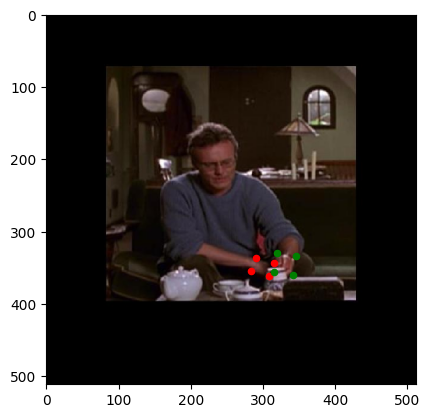

In [ ]:
testImage_path = '/home/darklord/Downloads/hand_dataset/training_dataset/training_data/images/Buffy_3.jpg'
testAnnotation_path = '/home/darklord/Downloads/hand_dataset/training_dataset/training_data/annotations/Buffy_3.mat'
img, coordinate = resize_edit_box(testImage_path,testAnnotation_path)
make_boundbox(img, coordinate)

In [ ]:
def distance(point1,point2):
    distance = ((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)**0.5
    return distance



def coordinate_reformat(coordinate):
    if coordinate.shape[0] >= 1:
        x_center = (coordinate[0,0,0] + coordinate[0,2,0])/2
        y_center = (coordinate[0,0,1] + coordinate[0,2,1])/2
        height = np.amax(coordinate[0,:,1]) - np.amin(coordinate[0,:,1])
        weight = np.amax(coordinate[0,:,0]) - np.amin(coordinate[0,:,0])
        output = np.array([x_center,y_center,height,weight]).reshape(1,4,1)


    if coordinate.shape[0] == 2:
        x_center_2 = (coordinate[1,0,0] + coordinate[1,2,0])/2
        y_center_2 = (coordinate[1,0,1] + coordinate[1,2,1])/2
        height_2 = np.amax(coordinate[1,:,1]) - np.amin(coordinate[1,:,1])
        weight_2 = np.amax(coordinate[1,:,0]) - np.amin(coordinate[1,:,0])
        temp = np.array([x_center_2,y_center_2,height_2,weight_2]).reshape(1,4,1)
        output = np.concatenate((output, temp), axis=0).reshape(2,4,1)

    return output


def coordinate_main(Newcoordinate):
    center_x = Newcoordinate[0,0,0]
    center_y = Newcoordinate[0,1,0]
    height = Newcoordinate[0,2,0]
    weidth = Newcoordinate[0,3,0]

    if Newcoordinate.shape[0] >= 1:
        a = np.array([center_x - (height/2 + weidth/2), center_y - (height/2 + weidth/2)])
        b = np.array([center_x - (height/2 - weidth/2), center_y - (height/2 - weidth/2)])
        c = np.array([center_x - (-height/2 - weidth/2), center_y - (-height/2 - weidth/2)])
        d = np.array([center_x - (-height/2 + weidth/2), center_y - (-height/2 + weidth/2)])
        temp1 = np.concatenate((a,b,c,d),axis = 0).reshape(1,4,2)


    if Newcoordinate.shape[0] == 2:
        center_x = Newcoordinate[1,0,0]
        center_y = Newcoordinate[1,1,0]
        height = Newcoordinate[1,2,0]
        weidth = Newcoordinate[1,3,0]
        a = np.array([center_x - (height/2 + weidth/2), center_y - (height/2 + weidth/2)])
        b = np.array([center_x - (height/2 - weidth/2), center_y - (height/2 - weidth/2)])
        c = np.array([center_x - (-height/2 - weidth/2), center_y - (-height/2 - weidth/2)])
        d = np.array([center_x - (-height/2 + weidth/2), center_y - (-height/2 + weidth/2)])
        temp2 = output = np.concatenate((a,b,c,d),axis = 0).reshape(1,4,2)

        output = np.concatenate((temp1, temp2), axis = 0)

    return output

(1, 887, 4)


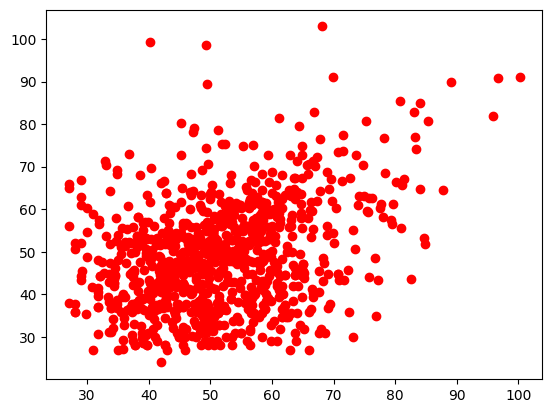

In [ ]:
all_coordinate = np.empty([2])
for dirname, _, filenames in os.walk('/home/darklord/Downloads/hand_dataset/training_dataset/training_data/annotations'):
    for filename in filenames:
        if 'Buffy' in filename:
            temp = coordinate_reformat(load_annotations(os.path.join(dirname, filename))).reshape(1,-1,4)
            if all_coordinate.shape[0] == 2:
                all_coordinate = temp
            else:
                all_coordinate = np.concatenate((temp,all_coordinate),axis = 1)

print(all_coordinate.shape)
plt.plot(all_coordinate[0,:,2],all_coordinate[0,:,3],'ro')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
all_coordinate = all_coordinate.reshape(-1,4)
HW = all_coordinate[:,2:4]
kmeans = KMeans(n_clusters=1, random_state=0).fit(HW)
kmeans.cluster_centers_

array([[51.49931633, 49.05936578]])

In [ ]:
anchor_DEFUALT = np.array([51.49931633, 49.05936578])

In [ ]:
def create_output(imgFile, annoFile, grid = 16):
    img, coordinate = resize_edit_box(imgFile, annoFile)
    coordinate = coordinate_reformat(coordinate)
    step = img.shape[1]/grid
    output = np.zeros((5,grid,grid))
    boundBox_grid_x = int(coordinate[0,0,0]/step)
    if boundBox_grid_x == 16: boundBox_grid_x = 15
    boundBox_grid_y = int(coordinate[0,1,0]/step)
    if boundBox_grid_y == 16: boundBox_grid_y = 15
    boundBox_x = (coordinate[0,0,0]% step)/step
    boundBox_y = (coordinate[0,1,0]% step)/step
    boundBox_height = coordinate[0,2,0]/(anchor_DEFUALT[0] * grid)
    boundBox_weidth = coordinate[0,3,0]/(anchor_DEFUALT[1] * grid)
    temp = np.array([1, boundBox_x, boundBox_y, boundBox_height, boundBox_weidth]).reshape(5)
    output[:,boundBox_grid_x,boundBox_grid_y] = temp

    if coordinate.shape[0] == 2:
        boundBox_grid_x = int(coordinate[1,0,0]/step)
        if boundBox_grid_x == 16: boundBox_grid_x = 15
        boundBox_grid_y = int(coordinate[1,1,0]/step)
        if boundBox_grid_y == 16: boundBox_grid_y = 15
        boundBox_x = (coordinate[1,0,0]% step)/step
        boundBox_y = (coordinate[1,1,0]% step)/step
        boundBox_height = coordinate[1,2,0]/(anchor_DEFUALT[0] * grid)
        boundBox_weidth = coordinate[1,3,0]/(anchor_DEFUALT[1] * grid)
        temp1 = np.array([1, boundBox_x, boundBox_y, boundBox_height, boundBox_weidth]).reshape(5)
        output[:,boundBox_grid_x,boundBox_grid_y] = temp1

    return img, output


In [ ]:
csv_head = ["no."]
for i in range(0,262144):
    csv_head.append("pixel " + str(i))
for i in range(0,256):
    csv_head.append("Objectness score(gride"+str(i)+")"), csv_head.append("Center x(gride"+str(i)+")"), csv_head.append("Center y(gride"+str(i)+")"), csv_head.append("Height(gride"+str(i)+")"), csv_head.append("Width(gride"+str(i)+")")

In [ ]:
def create_dataset(images,annotations):
    counter = 0
    final_output = []
    temp = []
    for IMGdir, _, IMGfiles in os.walk(images):
        for ANNOdir, _, ANNOfiles in os.walk(annotations):
             for img_file in IMGfiles:
                    for anno_file in ANNOfiles:
                        if counter == 1:break
                        idx = img_file.index('.jpg')
                        if 'Buffy' in img_file and img_file[0:idx]+'.mat' == anno_file:
                            img = os.path.join(IMGdir, img_file)
                            ann = os.path.join(ANNOdir, anno_file)
                            img, out = create_output(img,ann)
                            img = np.reshape(img,(1,-1)).tolist()[0]
                            out = np.reshape(out,(1,-1),order='F').tolist()[0]
                            temp = [counter] + img + out
                            final_output.append(temp)
                            counter+=1
    return final_output

In [ ]:
trainimg_dir = '/home/darklord/Downloads/hand_dataset/training_dataset/training_data/images'
trainanno_dir = '/home/darklord/Downloads/hand_dataset/training_dataset/training_data/annotations'
train = create_dataset(trainimg_dir, trainanno_dir)
testimg_dir = '../input/hand_dataset/test_dataset/test_data/images'
testanno_dir = '../input/hand_dataset/test_dataset/test_data/annotations'
test = create_dataset(testimg_dir, testanno_dir)

In [ ]:
write = []
write.append(csv_head),write.append(train[0])
with open('dataset.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(write)

In [ ]:
import pandas as pd
df = pd.read_csv("./dataset.csv")

In [ ]:
def generator(images, annotations , batch_size=32):
    """
    Yields the next training batch.
    """


    while True:
        counter = 0
        X_train = []
        y_train = []
        for IMGdir, _, IMGfiles in os.walk(images):
            for ANNOdir, _, ANNOfiles in os.walk(annotations):
                 for img_file in IMGfiles:
                        for anno_file in ANNOfiles:
                            if counter == batch_size:
                                X_train = np.array(X_train)
                                y_train = np.array(y_train)
                                yield X_train, y_train
                                X_train = []
                                y_train = []
                                counter = 0
                            idx = img_file.index('.jpg')
                            if 'Buffy' in img_file and img_file[0:idx]+'.mat' == anno_file:
                                img = os.path.join(IMGdir, img_file)
                                ann = os.path.join(ANNOdir, anno_file)
                                img, out = create_output(img,ann)
                                X_train.append(img)
                                y_train.append(out)
                                counter+=1

In [ ]:
train_generator = generator(trainimg_dir, trainanno_dir, batch_size=32)
test_generator =  generator(testimg_dir, testanno_dir, batch_size=32)

In [ ]:
x, y = next(train_generator)
print(x.shape)

(32, 512, 512, 3)
